In this project, I will analyze the results of an A/B test for the game Cookie Cats developed by Tactile Entertainment. The objective of the game is to connect three items in a line and clear the board to beat the level. As players progress through the levels, they will occasionally encounter gates where they will either have to wait a certain amount of time or make an in-app purchase to progress further. The goal of this project is to compare the difference of effects of setting the first gate at level 30 or level 40 on 1 and 7 day retention and number of rounds played.

In [1]:
# Import Pandas, Matplotlib and Seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data and show the first few lines
test_data = pd.read_csv('datasets/cookie_cats.csv')
test_data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


The data tracks players for 14 days after the install with the columns indicating the player ID, which test group they were assigned (gate 30 or 40), total number of rounds played (NOT levels passed, there's a big difference), and whether the player returned 1 day or 7 days after installing the game.

For the first step, let's use Panda's ```.info()``` method to check the data for missing values.

In [2]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


There are no missing values, so we can move on. Let's check out how many players played more than 100 rounds during the 14 day period.

In [3]:
# Get rows with values more than 100 for sum_gamerounds, group by version, and count the rows
test_data.query('sum_gamerounds > 100').groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,6095,6095,6095,6095
gate_40,6290,6290,6290,6290


Over 12,000 players completed more than 100 rounds of the game. Let's check out the data for the players with 10 highest values for ```sum_gamerounds```.

In [4]:
# Sort test_data by sum_gamerounds in descending order and return the top 10
test_data.sort_values(by='sum_gamerounds', ascending=False).head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True
46344,5133952,gate_30,2251,True,True
87007,9640085,gate_30,2156,True,True
36933,4090246,gate_40,2124,True,True
88328,9791599,gate_40,2063,True,True
6536,725080,gate_40,2015,True,True


A few observations:
- The highest number or rounds played is 49,845! That's 3561 per day if we assume those rounds were played over a 14-day span! (Value for ```retention_1``` is ```False``` in that row, so it must have taken less than 14 days.)
- There's no other player with over 3,000 total rounds played.
- The player with 3rd most number of rounds did not return after 7 days, which means that they played more than 2640/7 = 377 rounds per day.  

The highest number is an outlier (perhaps a glitch or someone trained a bot to play for them), so it would make sense to drop it from the data. The third number is also most likely a bot or a glitch. That brings a question: what numbers for that variable are reasonable?  
Let's check out how many players have played over 500 rounds total, or more than 35 rounds per day.

In [5]:
# Get rows with values more than 500 for sum_gamerounds, group by version, and count the rows 
test_data.query('sum_gamerounds > 500').groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,427,427,427,427
gate_40,429,429,429,429


There are 856 players with more than 500 rounds played.

In the next step, let's check out the distribution of players who played 200 rounds or less.

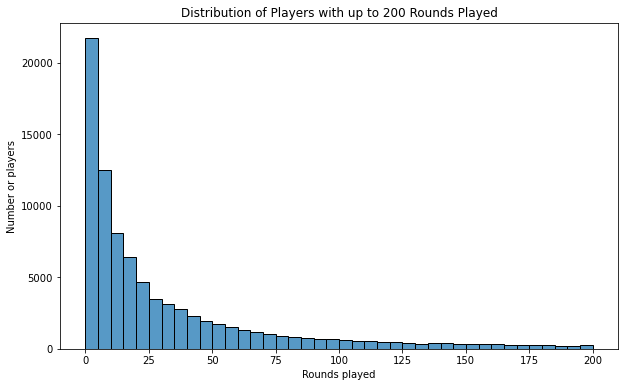

In [6]:
# Set figure size for better visibility
plt.figure(figsize=(10,6))

# Plot the distribution histogram with bin width of 5 and set labels
sns.histplot(data=test_data, x = 'sum_gamerounds', binwidth = 5, binrange = (0, 200))
plt.title('Distribution of Players with up to 200 Rounds Played')
plt.xlabel('Rounds played')
plt.ylabel('Number or players');

A good chunk of players stopped playing before completing 30 rounds. Let's get the exact number.

In [7]:
# Get the the players with less than 30 rounds played and count the unique IDs
test_data.query('sum_gamerounds < 30')['userid'].count()

56920

56920 out of 90189 players, or 63%, played less than 30 rounds.

30 rounds played is an important benchmark because our A/B test is around the gates that are placed at levels 30 and 40. If a player was assigned to the group 'gate_30' and played less than 30 rounds, it would not be possible for them to reach the gate, and therefore test the feature, since it would take them at least 30 rounds to beat 30 levels. Including those players in calculations would be similar to measuring the effectiveness of a drug by using participants who were assigned to the experimental group without actually being administered the drug.  

Also, since the features of the gates for both groups are the same (same wait time or in-app purchase price), we are measuring the effect of the 10 level difference, and not the gates themselves.  

Another point to consider is that the high dropout rate after very few rounds played is most likely due to the players not having enough interest in the game itself, and the location of the gate makes no difference. (Maybe no need for this paragraph.)

Using that as my reasoning, I will drop all the players that played less than 30 rounds from the data. 

(It is very possible that some of the players with more than 30 rounds played never made it to the first gate since it's possible that they lost a few rounds and didn't advance far enough. Therefore, a more reliable metric would be the highest level achieved, but I'll work with the data that's available.)

In [16]:
# Remove all rows with less than 30 rounds played from test_data in-place
test_data.drop(test_data.query('sum_gamerounds < 30').index, inplace = True)

Let's check ```test_data``` to make sure the drop went smoothly.

In [19]:
test_data.query('sum_gamerounds < 31')

,userid,version,sum_gamerounds,retention_1,retention_7
12,2132,gate_40,30,True,False
338,33954,gate_40,30,True,False
388,38249,gate_40,30,True,False
705,76662,gate_40,30,True,False
911,101864,gate_40,30,False,False
...,...,...,...,...,...
89718,9949586,gate_30,30,True,True
89730,9950957,gate_30,30,False,False
89786,9957250,gate_40,30,False,False
90175,9998125,gate_30,30,False,False


That looks good. Now, let's get back to the players that played a lot of rounds.  

I will drop rows with more than 500 rounds played because in my humble opinion, players with that many rounds played liked the game enough that I do not think whether the gate was at level 30 or at level 40 would matter to them. The number 500 is subjective and arguements could be made for a higher or lower number.

In [22]:
# Remove all rows with more than 500 rounds played from test_data in-place
test_data.drop(test_data.query('sum_gamerounds > 500').index, inplace = True)

Let's check ```test_data``` to verify.

In [24]:
test_data.query('sum_gamerounds > 499')

,userid,version,sum_gamerounds,retention_1,retention_7
8676,954991,gate_40,500,True,True
23304,2594923,gate_40,500,True,True
43416,4803763,gate_40,500,True,True
69959,7754204,gate_30,500,True,True


One more thing I would like to check before moving on to hypothesis testing is whether we have players who have values ```False``` for ```retention_1``` and ```True``` for ```retention_7```.

In [27]:
# Find rows with retention_1 as Fals AND retention_7 as True, group them by verion,
# and return the counts
test_data.query('retention_1 == False & retention_7 == True').groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,1153,1153,1153,1153
gate_40,1107,1107,1107,1107


There are 2260 rows that fit that description.  

The trouble I see with those values is that they could very well be players who installed the game, forgot about it, and remembered it the following week, effectively making day 7 their first day. So there's a discontinuity in their playing behavior that might not be correctly captured with the ```retention_1``` and ```retention_7``` values. So, I will drop those rows too.

In [29]:
# Remove all rows with more than 500 rounds played from test_data in-place
test_data.drop(test_data.query('retention_1 == False & retention_7 == True').index,
               inplace = True)

Another check to make sure the data was dropped correctly.

In [30]:
test_data.query('retention_1 == False & retention_7 == True').groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,


Now that I'm done trimming the data, I want to make sure both groups are evenly represented in the dataset, so I'll compare their counts.

In [31]:
test_data.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,15076,15076,15076,15076
gate_40,15077,15077,15077,15077


That's pretty even. I can now move on to comparing retention numbers by each version.

Data clean-up:  
- [x] Replace the line plot for players with 100 or fewer rounds played with a histogram of players with upto 200 rounds played
-[x] Remove players with less than 25 or 30 rounds played and explain why (didn't play enough to contribute to the trial)
-[x] Remove players who played over 500 rounds and explain why (gate 30 or 40 doesn't really affect them)
-[x] Remove players with False for day 1 retention and True for day 7 retention because their data is unrealiable  

For the remaining data:  
- [ ] Calculate day 1 retention by version
-[ ] Bootstrap the data 10,000 times
-[ ] Calculate the difference between means
-[ ] Compute p-value for the hypothesis  

Repeat the procedure for day 7 retention  
- [ ] Calculate day 7 retention by version
-[ ] Bootstrap the data 10,000 times
-[ ] Calculate the difference between means
-[ ] Compute p-value for the hypothesis

Repeat the procedure for rounds played
- [ ] Calculate rounds played by version
-[ ] Bootstrap the data 10,000 times
-[ ] Calculate the difference between means
-[ ] Compute p-value for the hypothesis

Consider doing calculations on a smaller subset (30-60 rounds played?)